<div width=50% style="display: block; margin: auto">
    <img src="figures/ucl-logo.svg" width=100%>
</div>

### UCL-ELEC0136 Data Acquisition and Processing Systems 2024
University College London
# Lab 5: Feature engineering
<hr>

*Q1:* In `task 2.1`, why do I need to transform the distribution of the data, the accuracy rate is decrasing. I have tried different subsets, but the best result is totally the same as the original data. Is it about the data shift thing or the scaling thing?  
*Q2:* In `task 3.2`, after doing the discretized, the accuracy after using SVM is totally the same as its previous one. Maybe any improvement on the comutational speed? I don't know...   
*Q3:* In `task 4.1`,The mutual information is increasing after the discretization step(regarding the `thalach` and `thalach_discrete`) as shown in the 'Mutual Information Criterion between Features and Output Variable'. Does the discretization changes the weights of features, I think it will have a reverse effect to the outcome. I'm confused.  
*Q4:* `Task4.2b:` shap.plots.waterfall(shap_values[0]), how to track the classification label? After the action of `shap_values = shap_values[:, :, 1]`, the classification info is removed, so how to use waterfall to track the exact data in the specific class.

Final result(Accuracy):  
Original: 0.67  
after Yeo-Johnson Transformation: 0.5  
after Quantile Transformation:  0.5  
after mutual information: 0.9  
after shaps: 0.4  
after pca: 0.47  

### Objectives

- Gain practical experience of dealing with real-world data
- Develop intuition and understanding of how operations on input features can affect model performance, and when to use them
- Develop familiarity different methods for assessing feature importance

### Outline

0. [Setup](#0-setup)
1. [Dealing with missing values](#1-dealing-with-missing-values)
2. [Transforming the distributions of features](#2-transforming-the-distributions-of-features)
3. [Discretising an input feature](#3-discretising-an-input-feature)
4. [Feature selection](#4-feature-selection)

<hr>

## 0. Setup


### 0.1 Prerequisites
First, we need to install the necessary packages for this lab. The packages are:

- `ucimlrepo`: real-life datasets for machine learning
- `scikit-learn`: statistical machine learning models
- `shap`: importance/relevancy metrics

<div class="alert alert-block alert-danger">
<h4>👩‍💻 Task 0.1: Install prerequisites</h4>

Install the packages that are required for this lab.

<details>
<summary>🔎 Hint</summary>

Remember, there are two steps to adding packages to your `daps` Python environment. You need to:
1. **Add the package to the requirements file**.
2. **Install all the requirements in the requirements file.**

</details>

</div>

### 0.2 Fetching the dataset

We'll be using a dataset containing data from a heart disease study in Cleveland, OH, USA.
Using this data, we should be able to predict whether a patient has heart disease, given various measurements that can be taken by a doctor.

For a more detailed explanation of the dataset, see [here](https://archive.ics.uci.edu/dataset/45/heart+disease).

In [1]:
from ucimlrepo import fetch_ucirepo 
import ssl

# Ignore ssl certificate verification
# We have to do this because in between writing the lab and delivering it, the SSL certificate of the UCIML website expired.
# This is a hacky fix. It is terrible practice.
# The correct thing to do would be to pester the website owners to update their SSL certificate, but we didn't have time.
ssl._create_default_https_context = ssl._create_unverified_context

heart_disease = fetch_ucirepo(id=45) 
  
X = heart_disease.data.features 
y = heart_disease.data.targets 
  
heart_disease.variables 

,name,role,type,demographic,description,units,missing_values
0,age,Feature,Integer,Age,None,years,no
1,sex,Feature,Categorical,Sex,None,None,no
2,cp,Feature,Categorical,None,None,None,no
3,trestbps,Feature,Integer,None,resting blood pressure (on admission to the ho...,mm Hg,no
4,chol,Feature,Integer,None,serum cholestoral,mg/dl,no
5,fbs,Feature,Categorical,None,fasting blood sugar > 120 mg/dl,None,no
6,restecg,Feature,Categorical,None,None,None,no
7,thalach,Feature,Integer,None,maximum heart rate achieved,None,no
8,exang,Feature,Categorical,None,exercise induced angina,None,no
9,oldpeak,Feature,Integer,None,ST depression induced by exercise relative to ...,None,no


In [2]:
X.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0


In [3]:
# Show some example outputs
y.head()

,num
0,0
1,2
2,1
3,0
4,0


Here, `num` is nonzero if the patient has some form of heart disease. We need to encode this to a binary variable (`0` or `1`).

<div class="alert alert-block alert-danger">
<h4>👩‍💻 Task 0.1: Encode output variable</h4>

Modify the `y` DataFrame so that entries are `1` if the patient has some form of heart disease and `0` otherwise.
</div>

In [4]:
# Add your code here:
y['num'] = y['num'].apply(lambda x: 1 if x != 0 else 0)

C:\Users\Zhou Yuanyuan\AppData\Local\Temp\ipykernel_25100\3815244971.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['num'] = y['num'].apply(lambda x: 1 if x != 0 else 0)


When evaluating the performance of a model, we need some data that the model hasn't seen. `scikit-learn` provides a handy function for producing a "test" (held-out) set, that is only used during evaluation:

In [5]:
from sklearn.model_selection import train_test_split

Note that we should preferably also use a *validation* set, but we're skipping it here for simplicity.

<div class="alert alert-block alert-danger">
<h4>👩‍💻 Task 0.2: Create training and test sets</h4>

Using `train_test_split` only, shuffle the `(X, y)` data and split it into a training and a test set, with 80% of the data in the training set.

For reproducibility, create a variable, `seed`, and set it to `42`. Use this to set the `random_state` of `train_test_split`. We'll reuse this variable in future to reseed other random processes.

Your variable names should be `(X_train, y_train)` and `(X_test, y_test)`.
</div>

In [6]:
# Add your code here:
seed = 42
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=seed)

In [7]:
# If this fails, it means you did something wrong!
assert len(x_train) == len(y_train)
assert len(x_test) == len(y_test)

### 0.3 Using a machine learning model

In this lab, we'll be using a [*support vector machine*](https://scikit-learn.org/stable/modules/svm.html) classifier. This is a simple but powerful statistical learning model provided by `scikit-learn`.

> Understanding the inner workings of this model is not the point of this lab, so we treat it as a black box.

We'll demo the SVM here using a **different** dataset:

In [8]:
from sklearn.datasets import load_iris
from models import support_vector_machine

# Load the iris dataset
X_iris, y_iris = load_iris(return_X_y=True)
# Train/test split
X_iris_train, X_iris_test, y_iris_train, y_iris_test = train_test_split(X_iris, y_iris, random_state=42)

model = support_vector_machine.train(X_iris_train, y_iris_train)
support_vector_machine.evaluate(model, X_iris_train, y_iris_train, X_iris_test, y_iris_test)

Score on training set: 95.54%
Score on test set: 100.00%


Note the functions we're using: 

- `support_vector_machine.train` takes in the training data and returns a trained classifier
- `support_vector_machine.evaluate` takes in the trained classifier, the training data, and the test data, and prints the score on the training and test sets.

In the rest of the lab, you'll see how the performance of the classifier on the **heart disease dataset** can be affected by feature engineering. At each stage, we'll retrain the model on the feature-engineered data and see how it performs.

<hr>

## 1. Dealing with missing values

The first thing to do when receiving data is to check whether there are any missing values.

As `X_train` is a `pd.DataFrame`, we can use the `isna` (short for "is not applicable" or "is not a number") method to generate a table that has `0` where the values are present, and `1` if the values are missing.

In [9]:
import pandas as pd
# missing_value = x_train.isna().astype(int)
rows_with_missing_values = x_train[x_train.isna().any(axis=1)]
print(rows_with_missing_values)

     age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
287   58    1   2       125   220    0        0      144      0      0.4   
266   52    1   4       128   204    1        0      156      1      1.0   
166   52    1   3       138   223    0        0      169      0      0.0   
87    53    0   3       128   216    0        2      115      0      0.0   
302   38    1   3       138   175    0        0      173      0      0.0   

     slope   ca  thal  
287      2  NaN   7.0  
266      2  0.0   NaN  
166      1  NaN   3.0  
87       1  0.0   NaN  
302      1  NaN   3.0  


<div class="alert alert-heading alert-danger" style="background-color: white; border: 2px solid; border-radius: 5px; color: #000; border-color:#AAA; padding: 10px">
    <b>💎 Tip</b>

- *Methods* are like functions that 'belong' to a specific object.
- In the output of the `help` command above, there's an example of using the `isna` method of a `pd.DataFrame` object.
- In `pandas`, you can often chain together methods on DataFrames in one line, like this:
  ```python
  X_train.sum().max()
  ```
- You might want to have the DataFrame documentation page open so that you can easily find any methods you need - this section should be solved using DataFrame methods alone (i.e., without manually iterating over rows in the data).

</div>

<div class="alert alert-block alert-danger">
<h4>👩‍💻 Task 1.1: Compute the percentage of missing values</h4>

Using methods of the `X_train` DataFrame, compute the percentage of missing values for each input feature.

</div>

In [10]:
# Add your code here:
# using info is much easier
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
dtypes: float64(3), int64(10)
memory usage: 30.9 KB


The missing values seem to only occur in two input features, and are missing in only a small amount of the training data.

<div class="alert alert-block alert-danger">
<h4>👩‍💻 Task 1.2: Deal with the missing values</h4>

For each feature that has missing values:

- Visualise the distribution of the values for that feature using a bar chart
  - Remember to label your axes
  - [Optional] If you like, you could also display bars for the NaN entries, which allows you to compare their frequency with the other categories
- Select a method for dealing with the missing values, and **justify your answer in the Q/A box below**. Also explain why one *other* method would be **unsuitable**.
- Implement your solution, and evaluate it using `evaluate`
  - Your solution should modify `X_train`, `y_train`, `X_test`, and `y_test`
  - Remember, **imputing missing values in the test set must only be done using information from the training set!**
</div>

<div class="alert alert-heading alert-danger" style="background-color: white; border: 2px solid; border-radius: 5px; color: #000; border-color:#AAA; padding: 10px">
    <b>💎 Tip</b>

- Create a copy of the unmodified dataframes so that if you make a mistake you don't have to re-run the notebook from the beginning!

</div>

d:\Software\conda\envs\daps\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Software\conda\envs\daps\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Software\conda\envs\daps\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Software\conda\envs\daps\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.

Text(0.5, 1.0, 'Missing Distribution of "thal" values')

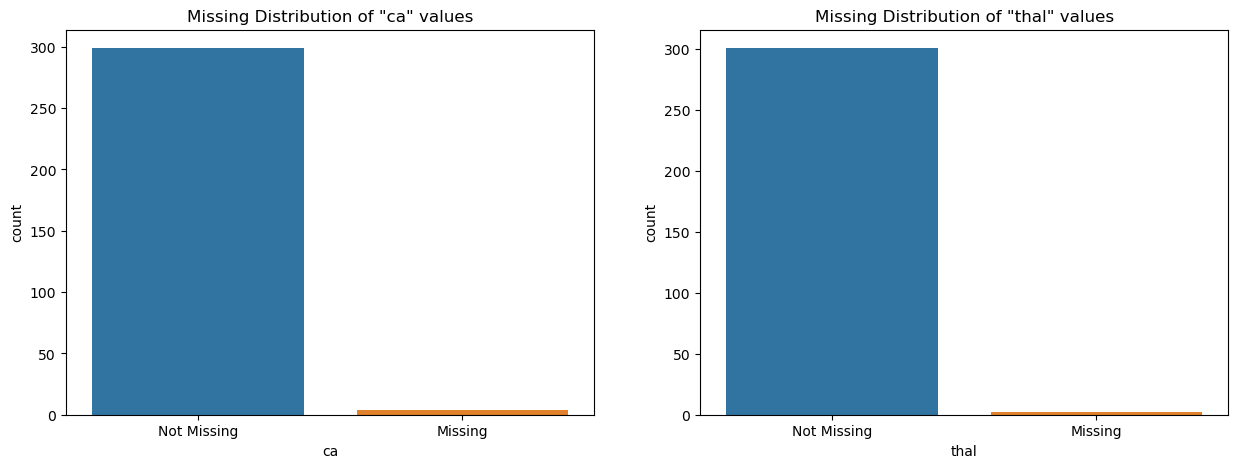

In [11]:
import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns
X1 = X.copy()

'''fig, axes = plt.subplots(1, 2, figsize=(15, 5))
df_ca = x_train['ca']
camissing = df_ca.value_counts(dropna=False)
camissing.plot(kind = 'bar', ax = axes[0])'''

X1['ca'] = pd.isnull(X1['ca'])
X1['thal'] = pd.isnull(X1['thal'])

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.barplot(x=X1['ca'].value_counts().index, y=X1['ca'].value_counts(),ax=axes[0])
sns.barplot(x=X1['thal'].value_counts().index, y=X1['thal'].value_counts(),ax=axes[1])

axes[0].set_xticklabels(['Not Missing', 'Missing'])
axes[0].set_title('Missing Distribution of "ca" values')
axes[1].set_xticklabels(['Not Missing', 'Missing'])
axes[1].set_title('Missing Distribution of "thal" values')

<div class="alert alert-block alert-danger">
<b>Q: What method(s) will you use for dealing with the missing values? Why?</b>
</div>

**A:** *drop the missing values for it's only a small portion, doesn't affect much to the overall dataset*

<div class="alert alert-block alert-danger">
<b>Q: What is an unsuitable method for dealing with the missing values? Why?</b>
</div>

**A:** *add your answer here*
As the number of missing values is so small to neglect, no need to do the imputation.

# Add your code here:


In [12]:
HDdata = pd.concat([X, y], axis=1).dropna(subset=['ca', 'thal'])
x1 = HDdata.iloc[:, :13]
y1 = HDdata.iloc[:,13:]

In [13]:
x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1, test_size=0.2,random_state=seed)

<hr>

## 2. Transforming the distributions of features

Many statistical classifiers work best if the distribution of each input feature follows a Gaussian distribution.

<div class="alert alert-block alert-danger">
<h4>👩‍💻 Task 2.1: Visualising feature distributions</h4>

- Using `matplotlib`, make a figure comprised of a subplot grid with 2 rows and 7 columns
- On each subplot, plot the **histogram** of one of the input features
- Which of the continuous variables appear to be **not** Gaussian-distributed? Write your answer in the Q/A box.
</div>

<div class="alert alert-heading alert-danger" style="background-color: white; border: 2px solid; border-radius: 5px; color: #000; border-color:#AAA; padding: 10px">
    <b>💎 Tip</b>

- If your figure has overlapping labels or looks a bit squashed, try using `plt.tight_layout()` at the end of the cell.

</div>

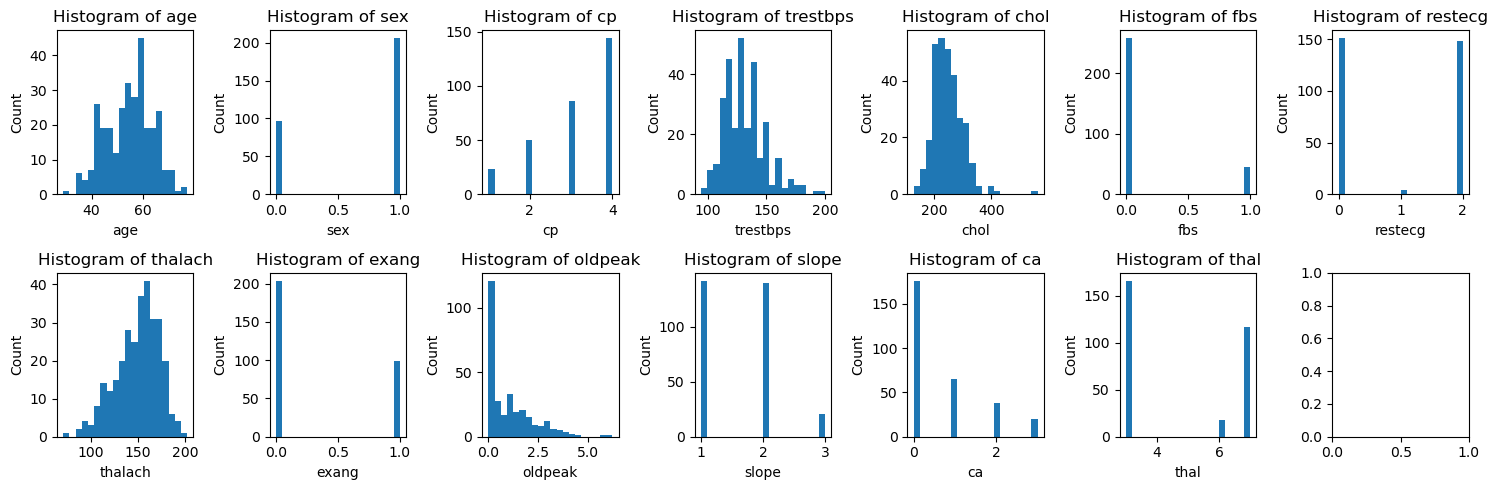

In [14]:
# Add your code here:
inputdf = HDdata.columns[:13]
fig, axes = plt.subplots(nrows=2, ncols=7, figsize=(15, 5), tight_layout = True)
axes = axes.flatten()

for i, feature in enumerate(inputdf):
    X[feature].plot(kind='hist', ax=axes[i], bins = 20)
    axes[i].set_title(f'Histogram of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Count')


<div class="alert alert-block alert-danger">
<b>Q: Which of the continuous variables are not Gaussian distributed?
</div>

**A:** *oldpeak, thalach*

<div class="alert alert-block alert-danger">
<h4>👩‍💻 Task 2.2: Transforming the distributions </h4>

- `scipy` provides an implementation of the Yeo-Johnson transformation. Find it (via your favourite search engine) and use it to transform the variables you identified above.
- Evaluate the model on the transformed data, and compare to the scores on the untransformed data.
- How have the scores of the model on the training and test set changed? Have we improved the model's ability to generalise? How do you know? Write your answer in the Q/A box.
- Visualise histograms of the transformed distributions

</div>


<div class="alert alert-heading alert-danger" style="background-color: white; border: 2px solid; border-radius: 5px; color: #000; border-color:#AAA; padding: 10px">
    <b>💎 Tip</b>

- Create a copy of the unmodified dataframes so that if you make a mistake you don't have to re-run the notebook from the beginning.
- Remember to re-train the model on the transformed data using `support_vector_machine.train`.

</div>

In [15]:
features_to_transform = ['thalach', 'oldpeak', 'trestbps','age']

In [16]:
# apply SVM on the unmodified data
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
svm_model = SVC()
svm_model.fit(x1_train, y1_train)


#evaluate
y_pred = svm_model.predict(x1_test)
accur = accuracy_score(y1_test, y_pred)
print(f'Accuracy on original test data: {accur:.4f}')

Accuracy on original test data: 0.6667


d:\Software\conda\envs\daps\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [17]:
# apply Yeo-Johnson Transformation
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
# Add your code here:
x2 = x1.copy()
y2 = y1.copy()

yj_transformer = PowerTransformer(method='yeo-johnson', standardize=True)

x2[features_to_transform] = yj_transformer.fit_transform(x2[features_to_transform])

#apply SVM
x2_train, x2_test, y2_train, y2_test = train_test_split(x2,y2,test_size=0.2,random_state=seed)
svm_model.fit(x2_train, y2_train)
#evaluate
y2_pred = svm_model.predict(x2_test)
accur2 = accuracy_score(y2_test, y2_pred)
print(f'Accuracy on original test data: {accur2:.4f}')

Accuracy on original test data: 0.5000


d:\Software\conda\envs\daps\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [18]:
# Since the performance in YJ is not good, I'm trying to use QuantileTransformer
x3 = x1.copy()
y3 = y1.copy()

qt_transformer = QuantileTransformer(n_quantiles=500, output_distribution="normal", random_state=seed)

x3[features_to_transform] = qt_transformer.fit_transform(x2[features_to_transform])

#apply SVM
x3_train, x3_test, y3_train, y3_test = train_test_split(x3,y3,test_size=0.2,random_state=seed)
svm_model.fit(x3_train, y3_train)
#evaluate
y3_pred = svm_model.predict(x3_test)
accur3 = accuracy_score(y3_test, y3_pred)
print(f'Accuracy on original test data: {accur3:.4f}')

Accuracy on original test data: 0.5000


d:\Software\conda\envs\daps\Lib\site-packages\sklearn\preprocessing\_data.py:2667: UserWarning: n_quantiles (500) is greater than the total number of samples (297). n_quantiles is set to n_samples.
  warnings.warn(
d:\Software\conda\envs\daps\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


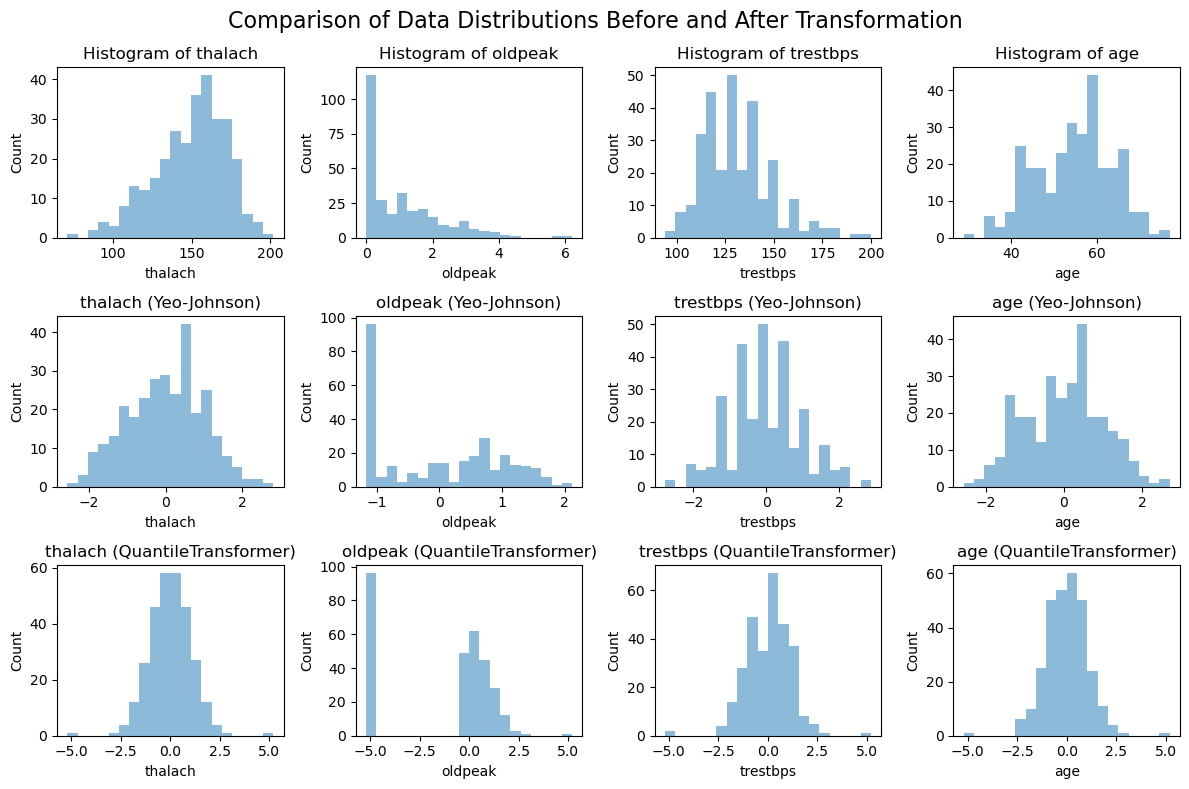

In [19]:
#visualize
rows, cols = 3, len(features_to_transform)
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 8), tight_layout=True)
axes = axes.flatten()

for i, feature in enumerate(features_to_transform):
    # Original Data
    x1[feature].plot(kind='hist', ax=axes[i], bins=20, alpha=0.5, label='Original')
    axes[i].set_title(f'Histogram of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Count')

    # Yeo-Johnson Transformed Data
    j = i + cols
    x2[feature].plot(kind='hist', ax=axes[j], bins=20, alpha=0.5, label='Yeo-Johnson')
    axes[j].set_title(f'{feature} (Yeo-Johnson)')
    axes[j].set_xlabel(feature)
    axes[j].set_ylabel('Count')

    # QuantileTransformer Transformed Data
    k = i + cols * 2
    x3[feature].plot(kind='hist', ax=axes[k], bins=20, alpha=0.5, label='QuantileTransformer')
    axes[k].set_title(f'{feature} (QuantileTransformer)')
    axes[k].set_xlabel(feature)
    axes[k].set_ylabel('Count')


# Overall Title and Axis Labels
fig.suptitle('Comparison of Data Distributions Before and After Transformation', fontsize=16)
plt.show()

<div class="alert alert-block alert-danger">
<b>Q: How have the scores of the model on the training and test set have changed? Have we improved the model's ability to generalise? How do you know?
</div>

**A**: *add your answer here*

The testing score is getting worse, with original accuracy score is 0.677  
After Yeo-Johnson Transformation: 0.5  
After Quantile Transformation: 0.5  

<hr>

## 3. Discretising an input feature

Sometimes, we might want to turn a continuous feature into a discrete one. Sometimes, this is necessary, as some models only work with discrete inputs. Other times, we might find that discretisation improves the model's performance, as it helps it to generalise better.


<div class="alert alert-block alert-danger">
<h4>👩‍💻 Task 3.1: Discretising a continuous feature</h4>

- The values in the transformed `thalach` column are high resolution and vary over a large range. This means that they might benefit from being discretised!
- Plot a **cumulative density histogram** of the values in the `thalach` column of the training data.
- Pandas provides `qcut`, a function for discretising a DataFrame based on quantiles (i.e., ensuring that each bin has a similar count). It also provides `cut`, a function for discretising based on predefined bin edges. Using these functions, discretise the `thalach` column into **10 bins**. The bin edges should be such that each bin has a similar count. Your final code should modify both training and test DataFrames.
- Evaluate the performance of the model with a continuous `thalach` column and with a discretised `thalach` column.
- Plot a bar chart of the binned `thalach` data.
- In the Q/A box, explain why this discretisation has improved the model's performance.

<details>
    <summary>🔎 Hint</summary>
    You can plot a cumulative density histogram by supplying additional keyword arguments to the standard histogram function.
    </details>

</div>

<div class="alert alert-heading alert-danger" style="background-color: white; border: 2px solid; border-radius: 5px; color: #000; border-color:#AAA; padding: 10px">
    <b>💎 Tip</b>

- Use data with no NaNs, and with Yeo-Johnson transformed variables.
- Remember, you can't use statistical properties of the test set when transforming the test data points.
- For the model we are using, the bin labels must be integers (for example, you could use `0` to represent `thalach < X`, `1` to represent `X < thalach < Y`, and so on).

</div>

plot a `cumulative density histogram` of the thalach column and `discretize` it into 10 bins using qcut

Text(0, 0.5, 'Cumulative Density')

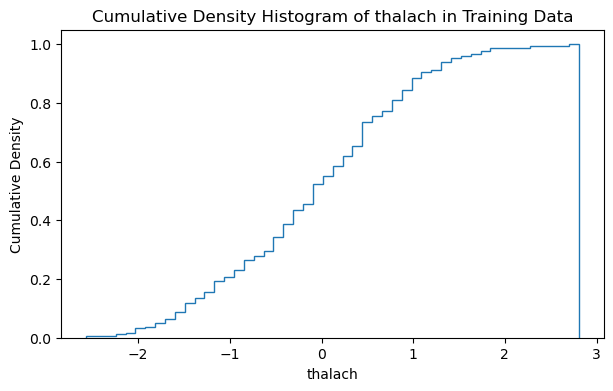

In [20]:
# Add your code here:
plt.figure(figsize=(7, 4))
plt.hist(x2_train['thalach'], bins=50, density=True, histtype='step', cumulative=True, label='Cumulative Density Histogram')
plt.title('Cumulative Density Histogram of thalach in Training Data')
plt.xlabel('thalach')
plt.ylabel('Cumulative Density')

In [21]:
# Discretize 'thalach' into 10 bins using qcut
num_bins = 10
x2_train['thalach_discrete'], bin_edges = pd.qcut(x2_train['thalach'], q=num_bins, retbins=True, labels=False, duplicates='drop')
x2_test['thalach_discrete'] = pd.cut(x2_test['thalach'], bins=bin_edges, labels=False, include_lowest=True)

In [22]:
print("Training DataFrame after discretization:")
print(x2_train[['thalach', 'thalach_discrete']].head())

print("\nTest DataFrame after discretization:")
print(x2_test[['thalach', 'thalach_discrete']].head())

Training DataFrame after discretization:
      thalach  thalach_discrete
277  0.012804                 4
262  0.961993                 8
30  -0.033362                 4
22   0.395708                 6
281  1.403155                 9

Test DataFrame after discretization:
      thalach  thalach_discrete
169 -0.599617                 2
214  0.395708                 6
63   0.908592                 8
155 -1.641425                 0
5    1.346648                 9


Evaluate the performance of the model with a continuous thalach column and a discretized thalach column

In [23]:
# Train the model using the continuous 'thalach' column
svc_model = SVC()
svc_model.fit(x2_train[['thalach']], y2_train)

y_pred_continuous = svc_model.predict(x2_test[['thalach']])
accuracy_continuous = accuracy_score(y2_test, y_pred_continuous)
print(f'Accuracy with continuous thalach: {accuracy_continuous:.4f}')


svc_model.fit(x2_train[['thalach_discrete']], y2_train)

y_pred_discretized = svc_model.predict(x2_test[['thalach_discrete']])
accuracy_discretized = accuracy_score(y2_test, y_pred_discretized)
print(f'Accuracy with discretized thalach: {accuracy_discretized:.4f}')

Accuracy with continuous thalach: 0.7500
Accuracy with discretized thalach: 0.7500


d:\Software\conda\envs\daps\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\Software\conda\envs\daps\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Text(0.5, 0.98, 'Discretized thalach')

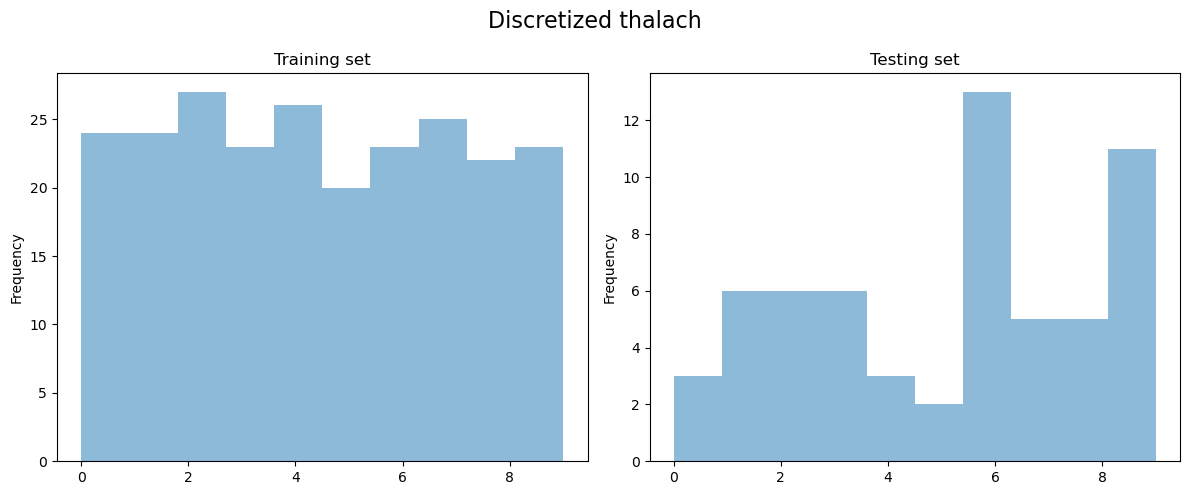

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5), tight_layout=True)
x2_train['thalach_discrete'].plot(kind='hist', ax=axes[0], alpha=0.5, label='Training set')
x2_test['thalach_discrete'].plot(kind='hist', ax=axes[1], alpha=0.5, label='Testing set')
axes[0].set_title('Training set')
axes[1].set_title('Testing set')
fig.suptitle('Discretized thalach',fontsize = 16)

<div class="alert alert-block alert-danger">
<b>Q: Why has discretising <code>thalach</code> improved the model's performance?</b>
</div>

**A:** I don't see the improvement.

<hr>

## 4. Feature selection


In this section, our goal is to reduce the number of inputs that the model requires to make a prediction, without losing too much performance. In fact, as we'll see, sometimes selecting only the most relevant features can even *boost* performance.

We want to select **5** input features, from the 13 possible candidates. We explore a few methods for identifying the most important features.

### 4.1 Using mutual information

`scikit-learn` provides `mutual_info_classif` to approximate the mutual information criterion for classification problems.

In [ ]:
from sklearn.feature_selection import mutual_info_classif
help(mutual_info_classif)

<div class="alert alert-block alert-danger">
<h4>👩‍💻 Task 4.1: Identifying important features using mutual information</h4>

- Compute the mutual information criterion for the training data using `mutual_info_classif`. Set the `random_state` parameter to the `seed` variable you defined before.
- Plot a bar chart of the results, where the x-axis labels are column names and the y-axis values are the mutual information between each column and the output variable.
- In the Q/A box, write the column names of the 5 features with highest mutual information with the output.
- Evaluate the model with all 13 features, and with only the top 5 mutual information features. **Has the performance of the model improved, stayed the same, or got worse? What does that tell us about the feature importance?** Answer in the Q/A box.
- Why might a model improve when the number of input features is reduced? Answer in the Q/A box.
</div>

<div class="alert alert-heading alert-danger" style="background-color: white; border: 2px solid; border-radius: 5px; color: #000; border-color:#AAA; padding: 10px">
<b>💎 Tip</b>

- Use the model that has been trained on the data with no NaNs, Yeo-Johnson transformed variables, and binned `thalach`.
- You can use `np.argsort(A)` to get the indices that would sort an array `A`. The indices can then be used to get a sorted version of something else.
- If you get a warning from `sklearn`, replace `y_train` with `np.ravel(y_train)`. This simply flattens the `y_train` array, to ensure that it's 1D.
- For this section, don't modify or overwrite any of the DataFrames! Create new copies, instead.
</div>

d:\Software\conda\envs\daps\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


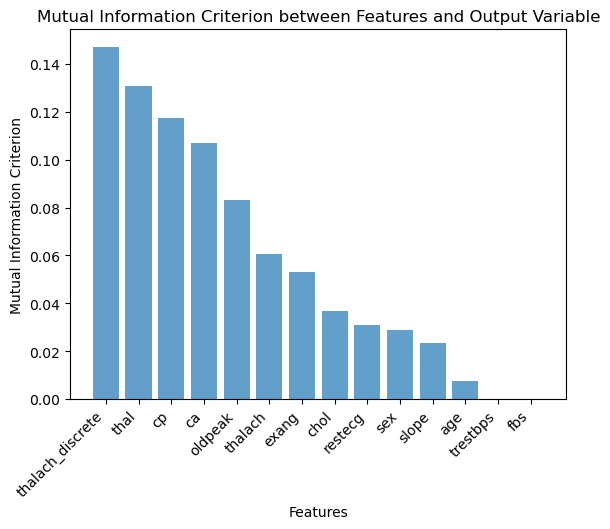

In [27]:
# Add your code here:
from sklearn.feature_selection import mutual_info_classif
mi_scores = mutual_info_classif(x2_train, y2_train, random_state=seed)
mi_scores_pairs = list(zip(x2_train.columns, mi_scores))
mi_scores_pairs.sort(key=lambda x: x[1], reverse=True)
sorted_columns, sorted_mi_scores = zip(*mi_scores_pairs)

plt.bar(sorted_columns, sorted_mi_scores, alpha=0.7)
plt.title('Mutual Information Criterion between Features and Output Variable')
plt.xlabel('Features')
plt.ylabel('Mutual Information Criterion')
plt.xticks(rotation=45, ha='right')
plt.show()

<div class="alert alert-block alert-danger">
<b>Q: What are the 5 columns with the highest mutual information with the output?</b>
</div>

**A**: *add your answer here*

Thalach, thal, cp, ca, oldpeak

In [28]:
x2_train.drop('thalach', axis=1, inplace=True)
x2_test.drop('thalach', axis=1, inplace=True)

In [29]:
svm_model.fit(x2_train, y2_train)
y_pred_all_features = svm_model.predict(x2_test)
accuracy_all_features = accuracy_score(y2_test, y_pred_all_features)
print(f'Accuracy with all 13 features: {accuracy_all_features:.4f}')

Accuracy with all 13 features: 0.5000


d:\Software\conda\envs\daps\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [30]:
from sklearn.feature_selection import SelectKBest
k_best = SelectKBest(mutual_info_classif, k=5)
x_train_top5 = k_best.fit_transform(x2_train, y2_train)
x_test_top5 = k_best.transform(x2_test)

svm_model.fit(x_train_top5, y2_train)

y_pred_top5_features = svm_model.predict(x_test_top5)
accuracy_top5_features = accuracy_score(y2_test, y_pred_top5_features)
print(f'Accuracy with top 5 features: {accuracy_top5_features:.4f}')

Accuracy with top 5 features: 0.9000


d:\Software\conda\envs\daps\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\Software\conda\envs\daps\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<div class="alert alert-block alert-danger">
<b>Q: Has the model performance improved, stayed the same, or got worse? What does that tell us about the feature importance?</b> 
</div>

**A**: *The model performance improved a lot, the accuracy is increased from 0.5 to 0.9. It shows that the feature importance is helping to improve the prediction performance.*

<div class="alert alert-block alert-danger">
<b>Q: Why might a model improve when the number of features is reduced?</b> 
</div>

**A**: *I guess maybe the other less important features don't actually have much relations with the result, but they introduce a lot false information and noises to the whole dataset. So removing these features help to keep the purity of the dataset and improve the prediction performance.*

### 4.2 Using SHAP

SHAP is a Python package for computing *Shapley values*, which are an idea from game theory. The basic principle is to **allocate credit for a model’s output among its input features**. Hence, for a given output prediction, we can gain insight into **which input features** contributed to the prediction.

SHAP is a hugely powerful tool, as you can apply it to any machine learning model (even LLMs!) to provide a greater degree of interpretability. However, not many people have heard of it. If you're interested, there's some really cool theory behind it [[paper](https://arxiv.org/abs/1705.07874)].

<div class="alert alert-block alert-danger">
<h4>👩‍💻 Task 4.2: Identifying important features using Shapley additive values (SHAP)</h4>

- Using `shap.utils.sample`, generate a subset of 100 points from the training set to act as 'background data'. Ideally, we'd use the full training set, but it gets quite slow to compute, so we use a subset for this lab.
- Create a SHAP explainer object using `shap.KernelExplainer`, your background data, and the class probability prediction function from our model (stored in `model.predict_proba`).
- Run the explainer on the test set, storing the result in a variable called `shap_values`.
- Using `shap.plots.bar`, visualise the average SHAP absolute values. What are the top 5 features according to SHAP? Does SHAP agree with the mutual information criterion? Answer in the Q/A box.
- Has the model performance improved, stayed the same, or got worse? What does that tell us about the feature importance?  Answer in the Q/A box.
<details>
<summary>🔎 Hint</summary>
If you're stuck, see whether you can find anything helpful on <a href=https://github.com/shap/shap#sample-notebooks>SHAP's Git repo</a>.
</details>
</div>

<div class="alert alert-heading alert-danger" style="background-color: white; border: 2px solid; border-radius: 5px; color: #000; border-color:#AAA; padding: 10px">
<b>💎 Tip</b>

- Use the model that has been trained on the data with no NaNs, Yeo-Johnson transformed variables, and binned `thalach`.
- **Remember to set the random state of the `sample()` function to the `seed` variable from before.**
- Computing SHAP values takes a minute or so, so why not watch [this explanation](https://www.youtube.com/watch?v=MQ6fFDwjuco) of what's going on while your code is running.
- The exact choice of SHAP explainer that you use depends on the model that you want to explain. As the model we're using (nonlinear support vector machine) can be formulated using kernels, we use a `KernelExplainer`. Don't worry if none of those words mean anything to you, it's not important for this course.
</div>

A useful resource of SHAPS: https://towardsdatascience.com/introduction-to-shap-with-python-d27edc23c454

In [68]:
import shap
from shap.utils import sample
shap.initjs()

# Sample 100 datapoints as "background data"
svm_model3 = SVC(probability=True)
svm_model3.fit(x2_train, y2_train)
background_data = sample(x2_train, 100, random_state=seed)
#print(background_data)
# Create a SHAP explainer
explainer = shap.KernelExplainer(svm_model3.predict_proba, background_data)

# Evaluate the explainer on the test set
shap_values = explainer(x2_train)


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


  0%|          | 0/237 [00:00<?, ?it/s]

In [74]:
# shap_values is an array of shape (n_samples, n_features, n_outputs)
# Confusingly, although we only have binary outcomes (1 or 0), SHAP still returns 2 outputs
# The output at index 1 is the probability that the patient has heart disease
shap_values = shap_values[:, :, 1]
print("Shape of x2_train:", x2_train.shape)
print("Shape of y2_train:", y2_train.shape)
print("Shape of background_data:", background_data.shape)

IndexError: too many indices for array

In [73]:
import numpy as np
'''
The first dimension (2) represents the number of classes.
The second dimension (60) represents the number of samples in your test set.
The third dimension (13) represents the number of features.
'''
np.shape(shap_values)

(237, 13)

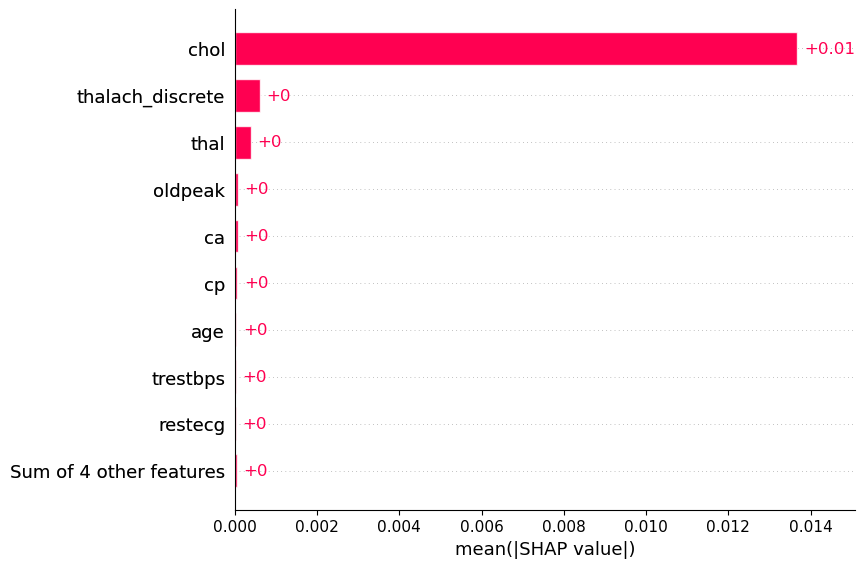

In [75]:
shap.plots.bar(shap_values)

<div class="alert alert-block alert-danger">
<b>Q: What are the top 5 features according to SHAP? Does SHAP agree with the mutual information criterion?</b> 
</div>

**A:** *chol, thalach_discrete, thal, (oldpeak, ca value0?)*

In [77]:
shap_features = ['chol','thalach_discrete','thal','oldpeak','ca']
shap_train = x2_train[shap_features]
shap_test = x2_test[shap_features]

In [78]:
svm_model4 = SVC()
svm_model4.fit(shap_train, y2_train)

y_pred_shap = svm_model.predict(shap_test)
accuracy_shap = accuracy_score(y2_test, y_pred_shap)
print(f'Accuracy with top 5 features: {accuracy_shap:.4f}')

Accuracy with top 5 features: 0.4000


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
X has feature names, but SVC was fitted without feature names


<div class="alert alert-block alert-danger">
<b>Q: Has the model performance improved, stayed the same, or got worse? What does that tell us about the feature importance?</b> 
</div>

**A**: *It's getting worse. I think feature extraction is really importance, it means a lot to the results of the prediction. If we get the feature importance in the right way, it can prevent data redundant, promote the efficiency and accuracy, vice versa.*

<div class="alert alert-block alert-warning">
<h4>👩‍💻 [Optional] Task 4.2b: Explaining single predictions with SHAP waterfall plots</h4>

SHAP can also be used to understand why the model predicted a particular output class for a particular input.

Using `shap.plots.waterfall`, compare 3 candidates (2 from the same class, and one from the other class). Draw some comparisons between them. For each patient, what are the most significant features? How sure is the model of its predictions?

</div>

In [100]:
len(shap_values)

237

In [118]:
y2_test

,num
169,0
214,1
63,0
155,1
5,0
77,0
185,0
159,0
9,1
140,0


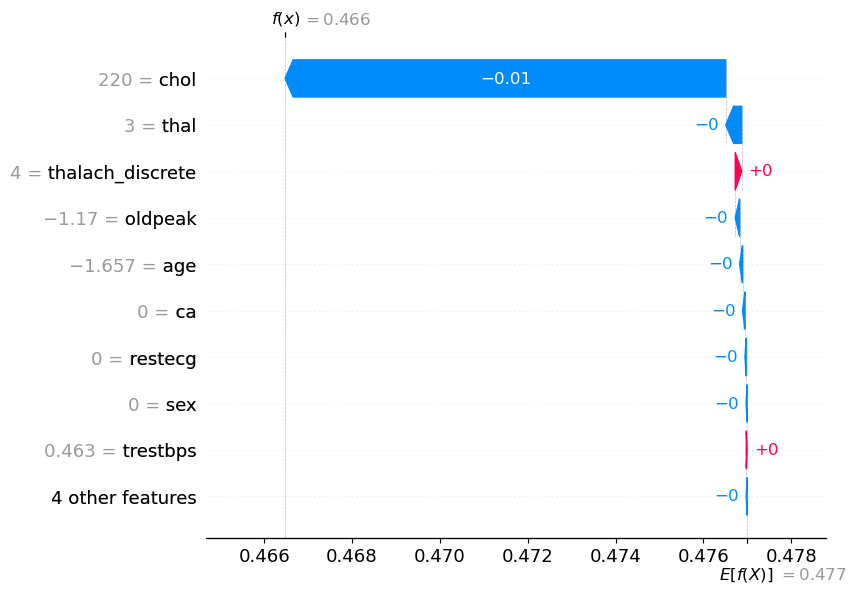

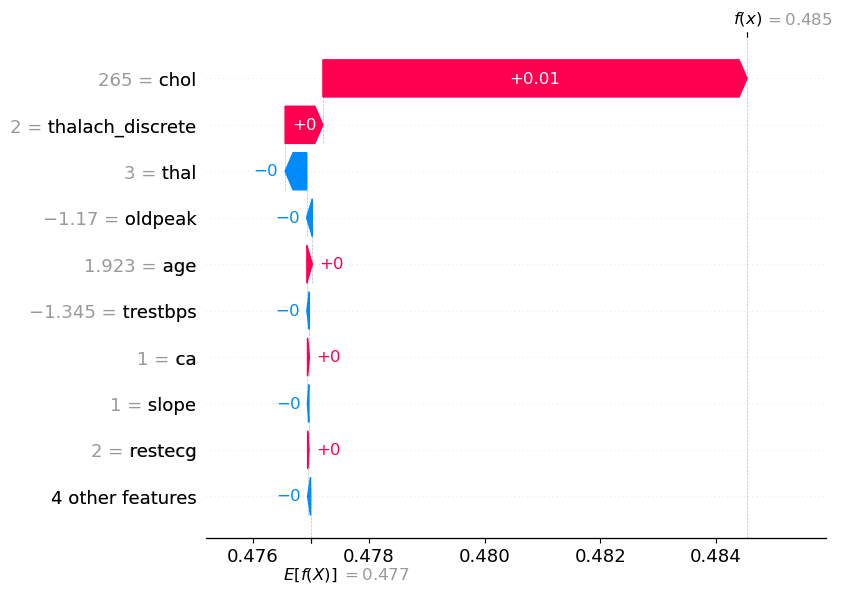

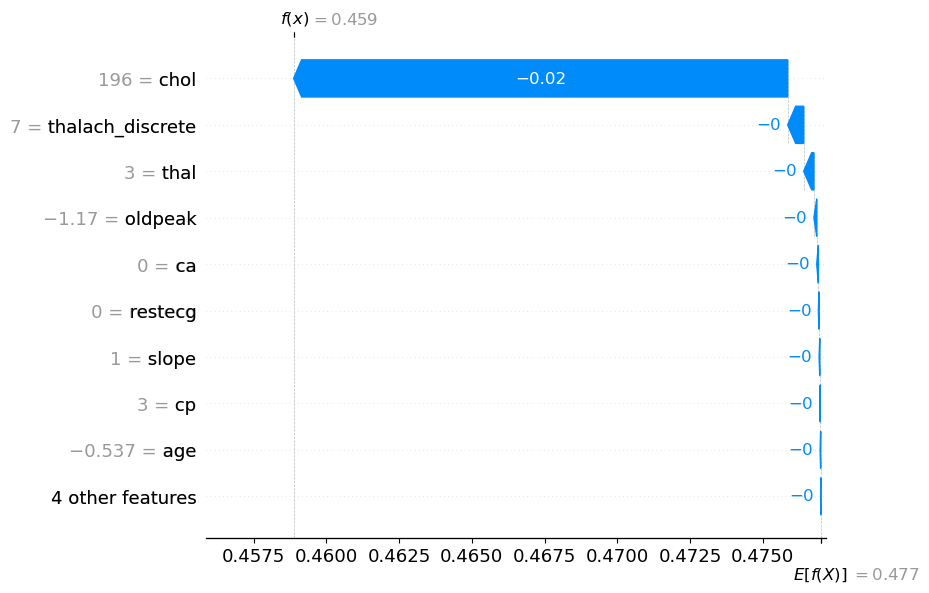

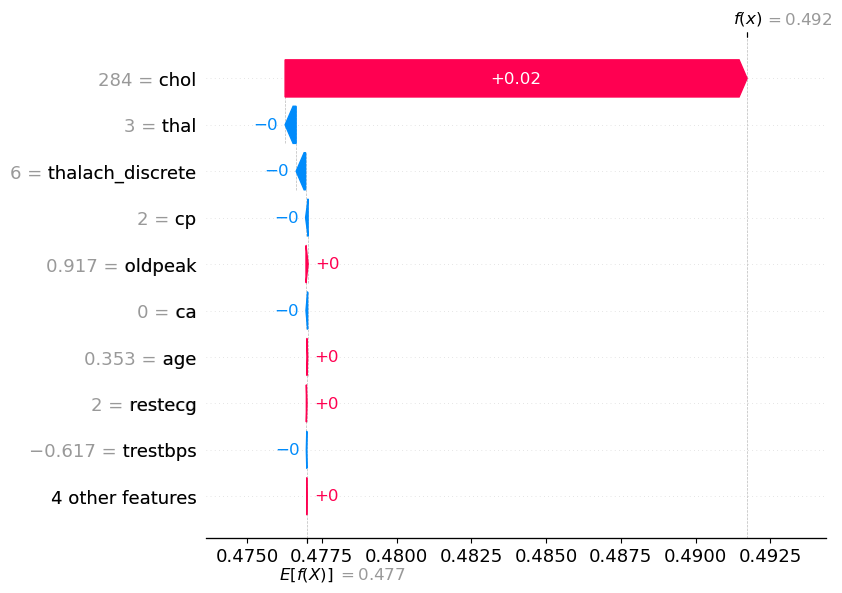

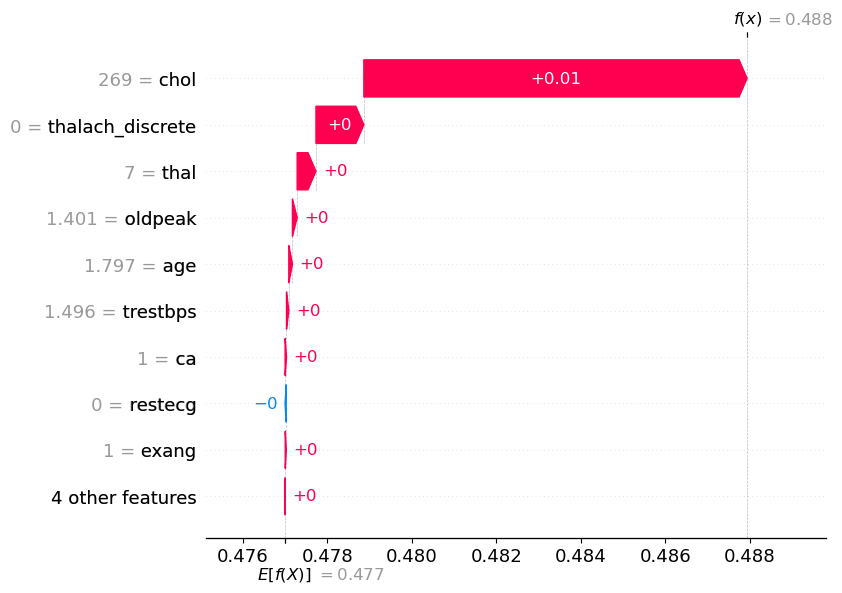

In [128]:
#y = 0
shap.plots.waterfall(shap_values[0])
shap.plots.waterfall(shap_values[-1])
#y = 1
shap.plots.waterfall(shap_values[-5])
shap.plots.waterfall(shap_values[3])
shap.plots.waterfall(shap_values[8])

<div class="alert alert-block alert-warning">
<b>Q: What are some similarities and differences between the patients? What are the most significant features? How sure is the model of its predictions?</b> 
</div>

**A**: *chol and thalach_discrete show differnt patterns in different classes.*

### 4.3 Using principal components

We're not limited to keeping the input features in the same geometrical space that they came in. In fact, there might be a way of projecting the data onto another co-ordinate system where their influence is easier to separate.

One method for doing this is *principal component analysis* (PCA), a concept from linear algebra. PCA effectively involves computing the eigenvalues and eigenvectors of the input data, and then using these as the new co-ordinate basis. In pictures, that looks something like this:

![PCA in 2D](figures/pca.png)

By only keeping the eigenvectors corresponding to the largest eigenvalues, we end up with a reduced set of input coordinates that should explain most of the data.

If you're interested in more detail, check out [this excellent tutorial](https://setosa.io/ev/principal-component-analysis/), which is the source of the above figure.

<div class="alert alert-block alert-danger">
<h4>👩‍💻 Task 4.3 Identifying important (transformed) features using PCA</h4>

- Scikit-learn provides a PCA function. Find its documentation and use it to compute the first 5 principal components of the training data. Transform the training and test data with these components.
- Compare the model performance with only the first 5 principal components and the whole data. How does the performance compare to the mutual information and SHAP methods? Answer in the Q/A box. 

</div>


In [147]:
# Add your code here:
from sklearn.decomposition import PCA

pca = PCA(n_components=5)
x2_train_pca = pca.fit_transform(x2_train)
x2_test_pca = pca.transform(x2_test)
y2_train_pca = y2_train.values.ravel()
y2_test_pca = y2_test.values.ravel()

svm_model5 = SVC()
svm_model5.fit(x2_train_pca, y2_train_pca)
y_pred_pca = svm_model5.predict(x2_test_pca)
accuracy_pca = accuracy_score(y2_test_pca, y_pred_pca)
print(f'Accuracy with PCA method: {accuracy_pca:.4f}')

Accuracy with PCA method: 0.4667


<div class="alert alert-block alert-danger">
<b>Q: How does the PCA performance compare to the mutual information and SHAP methods?</b> 
</div>

**A**: *worse than mutual information, better than shap*

<div class="alert alert-block alert-warning">
<h4>👩‍💻 [Optional] Task 4.3b: Quantifying the effect of more principal components</h4>

- With PCA, we can compute how well a given set of principal components represents the data.
- Create a plot showing how the percentage of variance explained by the principal components changes as the number of components is increased from 0 to 13.

<details>
<summary>🔎 Hint</summary>
The PCA object has a property that might be useful in computing the explained variance. The easiest way of generating the plot is with a loop.
</details>
</div>

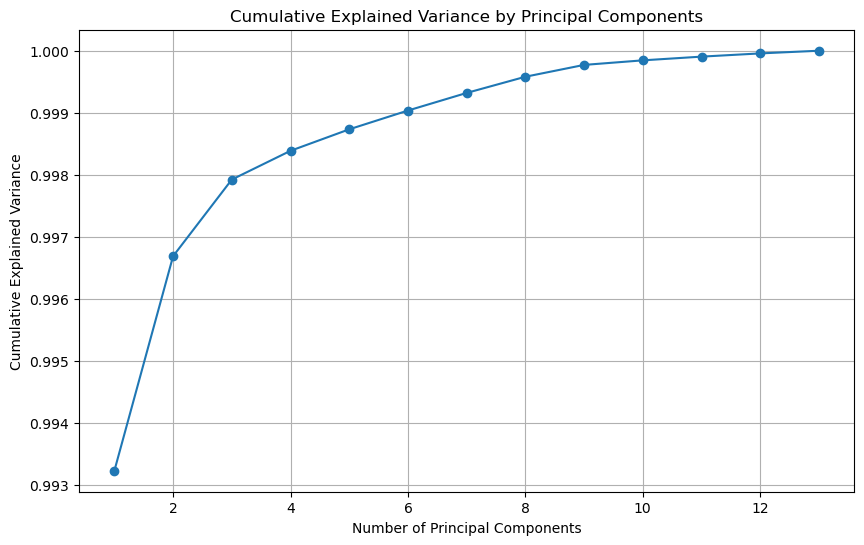

In [148]:
# Add your code here:

pca_all = PCA()
pca_all.fit(x2_train)
cumulative_variance = np.cumsum(pca_all.explained_variance_ratio_)

# Plot the explained variance as a function of the number of components
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')
plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

### 4.4 Conclusion

<div class="alert alert-block alert-danger">
<h4>👩‍💻 Task 4.4: Reviewing the results</h4>

- What are the strengths and weaknesses of the feature selection methods we've discussed in this section? Answer in the Q/A box below.
- Your answer should include reference to the **real-world scenario** of this dataset.
- Also consider how the methods are affected by any sources of **randomness**, and how they deal with **correlated features**.
</div>
<div class="alert alert-heading alert-danger" style="background-color: white; border: 2px solid; border-radius: 5px; color: #000; border-color:#AAA; padding: 10px">
<b>💎 Tip</b>

- You might have to carefully revisit the documentation for `mutual_info_classif` to spot how randomness plays a role in this method.
</div>

<div class="alert alert-block alert-danger">
<b>Q: What are the strengths and weaknesses of the feature selection methods we've discussed in this section?</b> 
</div>

**A**: *We have used 3 methods to do the feature selection: Mutual information, shaps, PCA*
1. Mutual Information:  
**Strengths**:   
   
 - Information Gain: Mutual information measures the dependency between variables, making it effective for selecting features that provide the most information about the target variable.
 - Non-Linearity: It can capture non-linear relationships between features and the target.
 - No Assumptions: Mutual information makes minimal assumptions about the underlying data distribution.  
**Weaknesses**:  
    
 - `Ignores Feature Redundancy`: Mutual information may not effectively deal with redundant features, and it might select correlated features.
 - Limited to Bivariate Analysis: It considers each feature independently, potentially missing interactions between multiple features.
    
2. Shaps:  
**Strengths:**   

- `Interpretability`: SHAP values provide a clear interpretation of the impact of each feature on the model's predictions.
- `Global and Local Insights`: SHAP values offer both global insights into feature importance across the dataset and local insights for specific predictions. 

**Weaknesses:**  

- `Computational Cost`: Calculating SHAP values for complex models can be computationally expensive.
- Model Dependency: SHAP values are model-specific, and different models might yield different explanations.  

3. PCA   
**Strengths**:   

- Dimensionality Reduction: PCA effectively reduces the dimensionality of the data while retaining most of its variance.
- `Decorrelation`: PCA transforms features into uncorrelated principal components, which can simplify the model.  
**Weaknesses**:  
- `Interpretability`: Principal components might be difficult to interpret in terms of the original features.
- Assumes Linearity: PCA assumes linear relationships between variables, and it may not capture complex non-linear patterns well.


1. Noise seems don't affect `mutual information`, since mutual information picks the most relevant and correlated features. There is a limit here, MI only focues on the single varible, can't handle the correlations between varibles.   
2. `PCA` is not sensitive to noises too, the results are deterministic and not affected by randomness. It effectively deals with correlated features by creating uncorrelated principal components.  
3. `SHAP` values handle correlated features well by distributing contributions appropriately. Robust to noise but varies in different dataset.
